In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory


## Reading data

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 0

tf.random.set_seed(SEED)

directory = '/content/drive/MyDrive/Dataset'

train_dataset = image_dataset_from_directory(directory=directory,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=SEED)

full_validation_dataset = image_dataset_from_directory(directory=directory,
                                                       label_mode='categorical',
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       shuffle=True,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=SEED)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [132]:

from keras.preprocessing.image import ImageDataGenerator
train_data=ImageDataGenerator(rescale=1./255)
valid_data=ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datas=ImageDataGenerator(rescale=1./255)

In [133]:
valid_datas=valid_data.flow_from_directory(directory=directory,
                                                       class_mode='categorical',
                                                       batch_size=BATCH_SIZE,
                                                       target_size=IMG_SIZE,
                                                       shuffle=True,
                                                       
                                                       subset='validation',
                                                       seed=SEED)
test_data_final=test_datas.flow_from_directory(directory=directory,
                                                       class_mode='categorical',
                                                       batch_size=BATCH_SIZE,
                                                       target_size=IMG_SIZE,
                                                       shuffle=True,
                                                      
                                                       
                                                       seed=SEED)

Found 1279 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


## Splitting Data

In [4]:
validation_batches = len(full_validation_dataset) #20% dataset
print(f'Total number of full_validation_dataset batches : {validation_batches}')

validation_dataset = full_validation_dataset.take(validation_batches // 2)
test_dataset = full_validation_dataset.skip(validation_batches // 2)

print(f'Number of batches in validation dataset : {len(validation_dataset)}')
print(f'Number of batches in test dataset : {len(test_dataset)}')

Total number of full_validation_dataset batches : 40
Number of batches in validation dataset : 20
Number of batches in test dataset : 20


In [5]:
class_names = train_dataset.class_names
class_names

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

## Exploring some samples

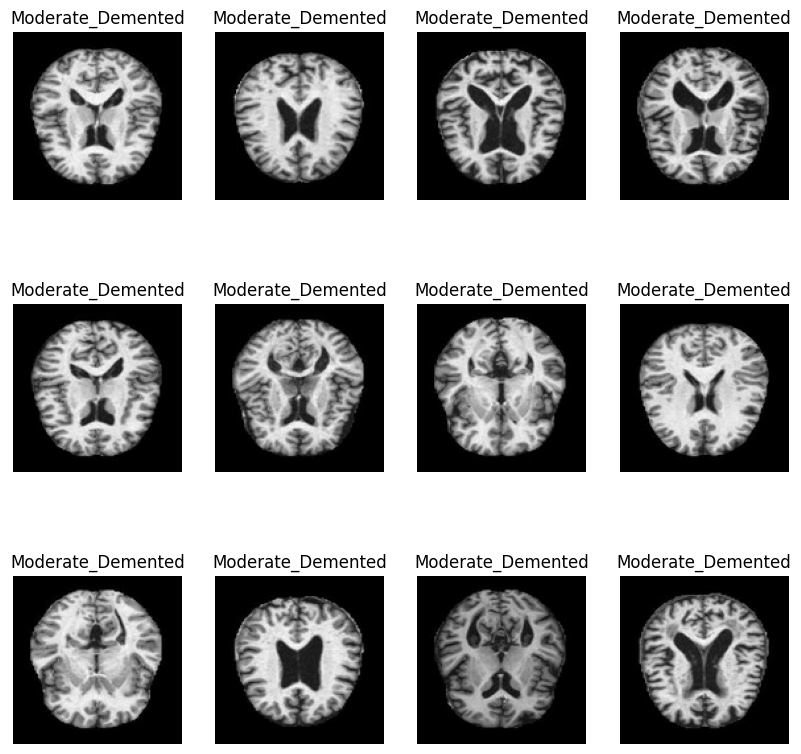

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(max(labels[i]))])
        plt.axis('off')

## Preventing a memory bottleneck


In [7]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [8]:
#preprocessing for rotation and zoom
def data_augmentar():
   
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [9]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

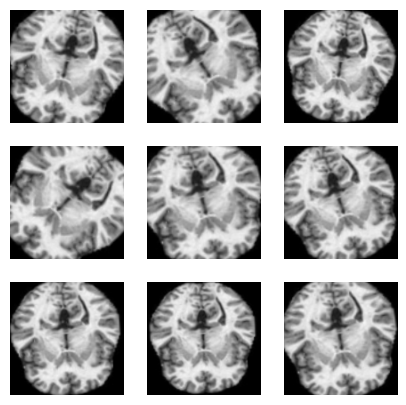

In [10]:
## applying data augmentation with a sample image.

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')

## Solving Imbalanced Data Problem

In [11]:
## Calculate number of samples in each class.

class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(directory+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

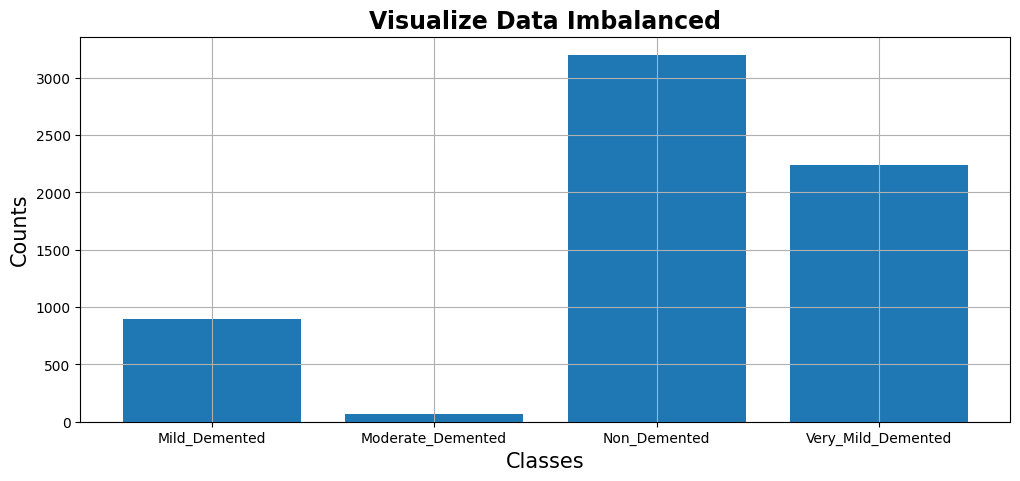

In [12]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [13]:
# Class_weight = (Total Number of images/Number of class x Images per class )

total = sum(class_counts.values())
number_of_classes = len([ 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'])

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


In [14]:
models=[]
acc=[]

### **VGG16**

In [15]:
base_model_3 = VGG16(input_shape=(128,128,3), 
                         include_top=False,
                         weights="imagenet")
for layer in base_model_3.layers:
  layer.trainable= False

58889256/58889256 [==============================] - 3s 0us/step


In [16]:
from keras.layers import Flatten,Dense
from keras.models import Model

x=Flatten()(base_model_3.output)
x=Dense(4098,activation="relu")(x)
x=Dense(4098,activation="relu")(x)
x=Dense(1000,activation="relu")(x)
x=Dense(4,activation="softmax")(x)

model3= Model(inputs=base_model_3.input,outputs=x)

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

def VGG16():
    input_layer = Input(shape=(224, 224, 3))

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='softmax', name='predictions')(x)

    model = Model(inputs=input_layer, outputs=x)
    return model


In [18]:
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.6 MB/s eta 0:00:00


In [19]:

model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model3.fit(train_dataset,
                    validation_data=validation_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs = 20,
                    verbose=1)

Epoch 1/20
160/160 [==============================] - 1390s 9s/step - loss: 8.4997 - accuracy: 0.5221 - auc: 0.7946 - precision: 0.5784 - recall: 0.3939 - val_loss: 0.8037 - val_accuracy: 0.6187 - val_auc: 0.8778 - val_precision: 0.7084 - val_recall: 0.4062
Epoch 2/20
160/160 [==============================] - 12s 75ms/step - loss: 0.7712 - accuracy: 0.6510 - auc: 0.8905 - precision: 0.7116 - recall: 0.5596 - val_loss: 0.6600 - val_accuracy: 0.6984 - val_auc: 0.9222 - val_precision: 0.7596 - val_recall: 0.6172
Epoch 3/20
160/160 [==============================] - 12s 74ms/step - loss: 0.6234 - accuracy: 0.7324 - auc: 0.9297 - precision: 0.7691 - recall: 0.6850 - val_loss: 0.6799 - val_accuracy: 0.7063 - val_auc: 0.9180 - val_precision: 0.7553 - val_recall: 0.6656
Epoch 4/20
160/160 [==============================] - 12s 73ms/step - loss: 0.5130 - accuracy: 0.7904 - auc: 0.9533 - precision: 0.8189 - recall: 0.7570 - val_loss: 0.5709 - val_accuracy: 0.7906 - val_auc: 0.9441 - val_precisi

In [20]:
models.append("VGG 16")
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [21]:
result = model3.evaluate(train_dataset)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')


160/160 [==============================] - 10s 59ms/step - loss: 0.1817 - accuracy: 0.9346 - auc: 0.9929 - precision: 0.9416 - recall: 0.9283
Train Loss = 0.18174448609352112
Train Accuracy = 0.9345703125
Train AUC = 0.9928778409957886
Train Precision = 0.9415610432624817
Train Recall = 0.9283202886581421


In [22]:
filepath = './Vgg_best_weights.hdf5'
# Stop the model when accuracy is not improving
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)
# Finding point where accuracy differs more
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [23]:
history3=model3.fit(train_dataset,
                        validation_data=validation_dataset,
                        steps_per_epoch=len(train_dataset)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=32)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9750 - auc: 0.9988 - precision: 0.9811 - recall: 0.9750
Epoch 1: val_accuracy improved from -inf to 0.83438, saving model to ./Vgg_best_weights.hdf5
5/5 [==============================] - 5s 1s/step - loss: 0.0854 - accuracy: 0.9750 - auc: 0.9988 - precision: 0.9811 - recall: 0.9750 - val_loss: 0.7112 - val_accuracy: 0.8344 - val_auc: 0.9479 - val_precision: 0.8386 - val_recall: 0.8281
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9563 - auc: 0.9967 - precision: 0.9563 - recall: 0.9563
Epoch 2: val_accuracy improved from 0.83438 to 0.85469, saving model to ./Vgg_best_weights.hdf5
5/5 [==============================] - 7s 2s/step - loss: 0.1391 - accuracy: 0.9563 - auc: 0.9967 - precision: 0.9563 - recall: 0.9563 - val_loss: 0.6139 - val_accuracy: 0.8547 - val_auc: 0.9545 - val_precision: 0.8608 - val_recall: 0.8500
Epoch 3/20
5/5 [=============================

In [24]:
model3.evaluate(test_dataset)

20/20 [==============================] - 85s 4s/step - loss: 0.4120 - accuracy: 0.8938 - auc: 0.9718 - precision: 0.8950 - recall: 0.8922


[0.4120297431945801,
 0.893750011920929,
 0.9718315601348877,
 0.8949843049049377,
 0.8921874761581421]

In [25]:
result = model3.evaluate(test_dataset)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)



20/20 [==============================] - 2s 55ms/step - loss: 0.4183 - accuracy: 0.9031 - auc: 0.9733 - precision: 0.9041 - recall: 0.8984
Test Loss = 0.41827160120010376
Test Accuracy = 0.903124988079071
Test AUC = 0.9733167290687561
Test Precision = 0.9040880799293518
Test Recall = 0.8984375


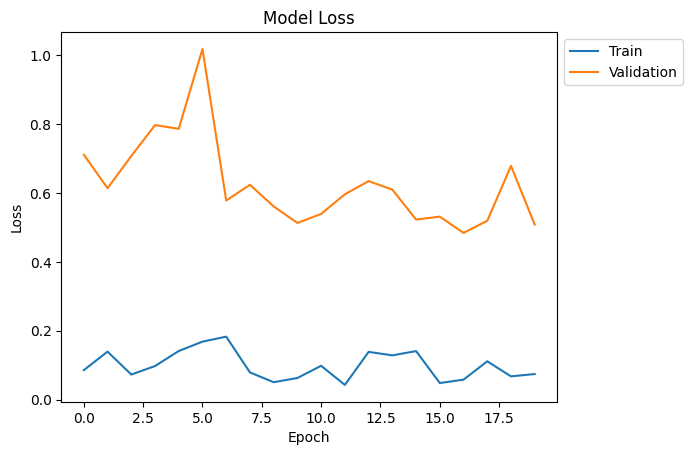

In [26]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

### ResNet50

In [27]:
base_model_2 = tf.keras.applications.ResNet50(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')
base_model_2.trainable = False


94765736/94765736 [==============================] - 5s 0us/step


In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model2 = tf.keras.Sequential([base_model_2, global_average_layer,
  keras.layers.BatchNormalization(),  
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])


In [29]:

model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model2.fit(train_dataset,
                    validation_data=validation_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs = 20,
                    verbose=1)


Epoch 1/20
160/160 [==============================] - 21s 75ms/step - loss: 0.9686 - accuracy: 0.5648 - auc_1: 0.8354 - precision_1: 0.6180 - recall_1: 0.4623 - val_loss: 0.9080 - val_accuracy: 0.5578 - val_auc_1: 0.8484 - val_precision_1: 0.6904 - val_recall_1: 0.3031
Epoch 2/20
160/160 [==============================] - 17s 104ms/step - loss: 0.7325 - accuracy: 0.6803 - auc_1: 0.9034 - precision_1: 0.7266 - recall_1: 0.6059 - val_loss: 0.7116 - val_accuracy: 0.6906 - val_auc_1: 0.9075 - val_precision_1: 0.7557 - val_recall_1: 0.5703
Epoch 3/20
160/160 [==============================] - 14s 85ms/step - loss: 0.5812 - accuracy: 0.7574 - auc_1: 0.9392 - precision_1: 0.7882 - recall_1: 0.7131 - val_loss: 0.6753 - val_accuracy: 0.6859 - val_auc_1: 0.9178 - val_precision_1: 0.7313 - val_recall_1: 0.6422
Epoch 4/20
160/160 [==============================] - 12s 75ms/step - loss: 0.4186 - accuracy: 0.8283 - auc_1: 0.9676 - precision_1: 0.8446 - recall_1: 0.8080 - val_loss: 0.5599 - val_accur

In [30]:
models.append("ResNet50")
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 256)              

In [31]:
result = model2.evaluate(train_dataset)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')


160/160 [==============================] - 10s 59ms/step - loss: 0.0354 - accuracy: 0.9891 - auc_1: 0.9994 - precision_1: 0.9891 - recall_1: 0.9889
Train Loss = 0.035397306084632874
Train Accuracy = 0.989062488079071
Train AUC = 0.9993938207626343
Train Precision = 0.9890603423118591
Train Recall = 0.9888671636581421


In [32]:
filepath = './Resnet50_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [33]:
history2=model2.fit(train_dataset,
                        validation_data=validation_dataset,
                        steps_per_epoch=len(train_dataset)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9812 - auc_1: 0.9997 - precision_1: 0.9812 - recall_1: 0.9812
Epoch 1: val_accuracy improved from -inf to 0.87031, saving model to ./Resnet50_best_weights.hdf5
5/5 [==============================] - 2s 502ms/step - loss: 0.0469 - accuracy: 0.9812 - auc_1: 0.9997 - precision_1: 0.9812 - recall_1: 0.9812 - val_loss: 0.4510 - val_accuracy: 0.8703 - val_auc_1: 0.9699 - val_precision_1: 0.8768 - val_recall_1: 0.8672
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9750 - auc_1: 0.9955 - precision_1: 0.9750 - recall_1: 0.9750
Epoch 2: val_accuracy improved from 0.87031 to 0.87813, saving model to ./Resnet50_best_weights.hdf5
5/5 [==============================] - 2s 577ms/step - loss: 0.0901 - accuracy: 0.9750 - auc_1: 0.9955 - precision_1: 0.9750 - recall_1: 0.9750 - val_loss: 0.4138 - val_accuracy: 0.8781 - val_auc_1: 0.9729 - val_precision_1: 0.8863 - val_recall_1: 

In [34]:
model2.evaluate(test_dataset)

20/20 [==============================] - 2s 44ms/step - loss: 0.5013 - accuracy: 0.8734 - auc_1: 0.9654 - precision_1: 0.8746 - recall_1: 0.8719


[0.5013140439987183,
 0.8734375238418579,
 0.9654009342193604,
 0.8746081590652466,
 0.871874988079071]

In [35]:
result = model3.evaluate(test_dataset)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

20/20 [==============================] - 2s 46ms/step - loss: 0.3570 - accuracy: 0.9078 - auc: 0.9767 - precision: 0.9104 - recall: 0.9047
Test Loss = 0.35698169469833374
Test Accuracy = 0.9078124761581421
Test AUC = 0.9767011404037476
Test Precision = 0.9103773832321167
Test Recall = 0.9046875238418579


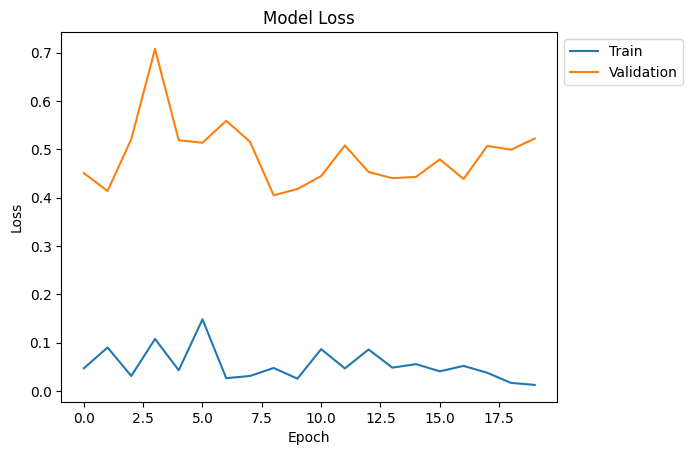

In [36]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## DenseNet169

In [37]:
base_model_4 = DenseNet169(input_shape=(128,128,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 3s 0us/step


In [38]:
for layer in base_model_4.layers:
    layer.trainable=False

In [39]:

model=Sequential()
model.add(base_model_4)

model.add(Dropout(0.5))
model.add(Flatten()
)
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [40]:
models.append(model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 4, 4, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 4, 4, 1664)        0         
                                                                 
 flatten_1 (Flatten)         (None, 26624)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 26624)            106496    
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 2048)              54528000  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [41]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs = 20,
                    verbose=1)


Epoch 1/20
160/160 [==============================] - 30s 110ms/step - loss: 1.1089 - accuracy: 0.5852 - auc_2: 0.8379 - precision_2: 0.6061 - recall_2: 0.5434 - val_loss: 0.8455 - val_accuracy: 0.6844 - val_auc_2: 0.8908 - val_precision_2: 0.7138 - val_recall_2: 0.6313
Epoch 2/20
160/160 [==============================] - 13s 78ms/step - loss: 0.7161 - accuracy: 0.7096 - auc_2: 0.9143 - precision_2: 0.7369 - recall_2: 0.6783 - val_loss: 0.5862 - val_accuracy: 0.7734 - val_auc_2: 0.9390 - val_precision_2: 0.8034 - val_recall_2: 0.7406
Epoch 3/20
160/160 [==============================] - 13s 79ms/step - loss: 0.5497 - accuracy: 0.7732 - auc_2: 0.9463 - precision_2: 0.7923 - recall_2: 0.7516 - val_loss: 0.4360 - val_accuracy: 0.8359 - val_auc_2: 0.9641 - val_precision_2: 0.8581 - val_recall_2: 0.8125
Epoch 4/20
160/160 [==============================] - 13s 78ms/step - loss: 0.4648 - accuracy: 0.8146 - auc_2: 0.9610 - precision_2: 0.8270 - recall_2: 0.7992 - val_loss: 0.3277 - val_accur

In [42]:
models.append("DenseNet169")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 4, 4, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 4, 4, 1664)        0         
                                                                 
 flatten_1 (Flatten)         (None, 26624)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 26624)            106496    
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 2048)              54528000  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [43]:
result = model2.evaluate(train_dataset)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

160/160 [==============================] - 9s 55ms/step - loss: 0.0319 - accuracy: 0.9926 - auc_1: 0.9989 - precision_1: 0.9928 - recall_1: 0.9924
Train Loss = 0.031923580914735794
Train Accuracy = 0.9925781488418579
Train AUC = 0.998894989490509
Train Precision = 0.9927706122398376
Train Recall = 0.992382824420929


In [44]:
filepath = './DenseNet169_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [45]:
history4 = model.fit(train_dataset,
                        validation_data=validation_dataset,
                        steps_per_epoch=len(train_dataset)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9812 - auc_2: 0.9996 - precision_2: 0.9812 - recall_2: 0.9812

5/5 [==============================] - 2s 407ms/step - loss: 0.0567 - accuracy: 0.9812 - auc_2: 0.9996 - precision_2: 0.9812 - recall_2: 0.9812 - val_loss: 0.1258 - val_accuracy: 0.9578 - val_auc_2: 0.9951 - val_precision_2: 0.9577 - val_recall_2: 0.9563
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9438 - auc_2: 0.9961 - precision_2: 0.9438 - recall_2: 0.9438

5/5 [==============================] - 2s 392ms/step - loss: 0.1512 - accuracy: 0.9438 - auc_2: 0.9961 - precision_2: 0.9438 - recall_2: 0.9438 - val_loss: 0.1264 - val_accuracy: 0.9547 - val_auc_2: 0.9961 - val_precision_2: 0.9561 - val_recall_2: 0.9531
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9375 - auc_2: 0.9931 - precision_2: 0.9375 - recall_2: 0.9375

5/5 [==============================] - 2s 385ms/step - loss: 0.1605 - accuracy: 0.9375 - auc_2: 0.9931 - precision_2: 0.9375 - recall_2: 0.9375 - val_loss: 0.1140 - val_accuracy: 0.9547 - val_auc_2: 0.9975 - val_precision_2: 0.9546 - val_recall_2: 0.9531
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9563 - auc_2: 0.9835 - precision_2: 0.9563 - recall_2: 0.9563

5/5 [==============================] - 2s 419ms/step - loss: 0.1942 - accuracy: 0.9563 - auc_2: 0.9835 - precision_2: 0.9563 - recall_2: 0.9563 - val_loss: 0.1248 - val_accuracy: 0.9484 - val_auc_2: 0.9971 - val_precision_2: 0.9499 - val_recall_2: 0.9484
Epoch 5/20
5/5 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9500 - auc_2: 0.9968 - precision_2: 0.9500 - recall_2: 0.9500

5/5 [==============================] - 2s 595ms/step - loss: 0.1211 - accuracy: 0.9500 - auc_2: 0.9968 - precision_2: 0.9500 - recall_2: 0.9500 - val_loss: 0.1284 - val_accuracy: 0.9484 - val_auc_2: 0.9960 - val_precision_2: 0.9513 - val_recall_2: 0.9453
Epoch 6/20
5/5 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9438 - auc_2: 0.9945 - precision_2: 0.9497 - recall_2: 0.9438

5/5 [==============================] - 2s 406ms/step - loss: 0.1676 - accuracy: 0.9438 - auc_2: 0.9945 - precision_2: 0.9497 - recall_2: 0.9438 - val_loss: 0.1194 - val_accuracy: 0.9469 - val_auc_2: 0.9974 - val_precision_2: 0.9498 - val_recall_2: 0.9453
Epoch 7/20
5/5 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9312 - auc_2: 0.9949 - precision_2: 0.9367 - recall_2: 0.9250

5/5 [==============================] - 2s 395ms/step - loss: 0.1636 - accuracy: 0.9312 - auc_2: 0.9949 - precision_2: 0.9367 - recall_2: 0.9250 - val_loss: 0.1164 - val_accuracy: 0.9578 - val_auc_2: 0.9974 - val_precision_2: 0.9591 - val_recall_2: 0.9516
Epoch 8/20
5/5 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9563 - auc_2: 0.9979 - precision_2: 0.9563 - recall_2: 0.9563

5/5 [==============================] - 2s 395ms/step - loss: 0.1050 - accuracy: 0.9563 - auc_2: 0.9979 - precision_2: 0.9563 - recall_2: 0.9563 - val_loss: 0.1332 - val_accuracy: 0.9516 - val_auc_2: 0.9966 - val_precision_2: 0.9544 - val_recall_2: 0.9484
Epoch 9/20
5/5 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9750 - auc_2: 0.9992 - precision_2: 0.9811 - recall_2: 0.9750

5/5 [==============================] - 2s 381ms/step - loss: 0.0734 - accuracy: 0.9750 - auc_2: 0.9992 - precision_2: 0.9811 - recall_2: 0.9750 - val_loss: 0.1321 - val_accuracy: 0.9500 - val_auc_2: 0.9968 - val_precision_2: 0.9513 - val_recall_2: 0.9469
Epoch 10/20
5/5 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9563 - auc_2: 0.9968 - precision_2: 0.9563 - recall_2: 0.9563

5/5 [==============================] - 2s 392ms/step - loss: 0.1316 - accuracy: 0.9563 - auc_2: 0.9968 - precision_2: 0.9563 - recall_2: 0.9563 - val_loss: 0.1566 - val_accuracy: 0.9438 - val_auc_2: 0.9942 - val_precision_2: 0.9466 - val_recall_2: 0.9422
Epoch 11/20
5/5 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9625 - auc_2: 0.9972 - precision_2: 0.9682 - recall_2: 0.9500

5/5 [==============================] - 2s 382ms/step - loss: 0.1164 - accuracy: 0.9625 - auc_2: 0.9972 - precision_2: 0.9682 - recall_2: 0.9500 - val_loss: 0.1196 - val_accuracy: 0.9547 - val_auc_2: 0.9973 - val_precision_2: 0.9577 - val_recall_2: 0.9547
Epoch 12/20
5/5 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9375 - auc_2: 0.9913 - precision_2: 0.9434 - recall_2: 0.9375

5/5 [==============================] - 2s 514ms/step - loss: 0.1712 - accuracy: 0.9375 - auc_2: 0.9913 - precision_2: 0.9434 - recall_2: 0.9375 - val_loss: 0.1344 - val_accuracy: 0.9531 - val_auc_2: 0.9959 - val_precision_2: 0.9545 - val_recall_2: 0.9500
Epoch 13/20
5/5 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9563 - auc_2: 0.9981 - precision_2: 0.9563 - recall_2: 0.9563

5/5 [==============================] - 3s 741ms/step - loss: 0.1011 - accuracy: 0.9563 - auc_2: 0.9981 - precision_2: 0.9563 - recall_2: 0.9563 - val_loss: 0.1226 - val_accuracy: 0.9531 - val_auc_2: 0.9964 - val_precision_2: 0.9545 - val_recall_2: 0.9516
Epoch 14/20
5/5 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9563 - auc_2: 0.9953 - precision_2: 0.9563 - recall_2: 0.9563

5/5 [==============================] - 2s 384ms/step - loss: 0.1531 - accuracy: 0.9563 - auc_2: 0.9953 - precision_2: 0.9563 - recall_2: 0.9563 - val_loss: 0.1310 - val_accuracy: 0.9531 - val_auc_2: 0.9959 - val_precision_2: 0.9545 - val_recall_2: 0.9500
Epoch 15/20
5/5 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9375 - auc_2: 0.9962 - precision_2: 0.9434 - recall_2: 0.9375

5/5 [==============================] - 2s 392ms/step - loss: 0.1466 - accuracy: 0.9375 - auc_2: 0.9962 - precision_2: 0.9434 - recall_2: 0.9375 - val_loss: 0.1173 - val_accuracy: 0.9594 - val_auc_2: 0.9975 - val_precision_2: 0.9593 - val_recall_2: 0.9578
Epoch 16/20
5/5 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9438 - auc_2: 0.9924 - precision_2: 0.9434 - recall_2: 0.9375

5/5 [==============================] - 2s 392ms/step - loss: 0.1818 - accuracy: 0.9438 - auc_2: 0.9924 - precision_2: 0.9434 - recall_2: 0.9375 - val_loss: 0.1337 - val_accuracy: 0.9516 - val_auc_2: 0.9968 - val_precision_2: 0.9515 - val_recall_2: 0.9500
Epoch 17/20
5/5 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9625 - auc_2: 0.9974 - precision_2: 0.9623 - recall_2: 0.9563

5/5 [==============================] - 2s 384ms/step - loss: 0.1144 - accuracy: 0.9625 - auc_2: 0.9974 - precision_2: 0.9623 - recall_2: 0.9563 - val_loss: 0.1518 - val_accuracy: 0.9484 - val_auc_2: 0.9952 - val_precision_2: 0.9498 - val_recall_2: 0.9469
Epoch 18/20
5/5 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9438 - auc_2: 0.9973 - precision_2: 0.9438 - recall_2: 0.9438

5/5 [==============================] - 2s 379ms/step - loss: 0.1224 - accuracy: 0.9438 - auc_2: 0.9973 - precision_2: 0.9438 - recall_2: 0.9438 - val_loss: 0.1239 - val_accuracy: 0.9594 - val_auc_2: 0.9970 - val_precision_2: 0.9608 - val_recall_2: 0.9578
Epoch 19/20
5/5 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.9500 - auc_2: 0.9979 - precision_2: 0.9560 - recall_2: 0.9500

5/5 [==============================] - 3s 705ms/step - loss: 0.1147 - accuracy: 0.9500 - auc_2: 0.9979 - precision_2: 0.9560 - recall_2: 0.9500 - val_loss: 0.1086 - val_accuracy: 0.9563 - val_auc_2: 0.9979 - val_precision_2: 0.9591 - val_recall_2: 0.9531
Epoch 20/20
5/5 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9688 - auc_2: 0.9994 - precision_2: 0.9688 - recall_2: 0.9688

5/5 [==============================] - 2s 398ms/step - loss: 0.0614 - accuracy: 0.9688 - auc_2: 0.9994 - precision_2: 0.9688 - recall_2: 0.9688 - val_loss: 0.1290 - val_accuracy: 0.9516 - val_auc_2: 0.9971 - val_precision_2: 0.9515 - val_recall_2: 0.9500


In [ ]:
model.evaluate(test_dataset)

In [96]:
result = model3.evaluate(test_dataset)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

20/20 [==============================] - 2s 57ms/step - loss: 0.4699 - accuracy: 0.8875 - auc: 0.9680 - precision: 0.8887 - recall: 0.8859
Test Loss = 0.4698980748653412
Test Accuracy = 0.887499988079071
Test AUC = 0.9679679274559021
Test Precision = 0.8887147307395935
Test Recall = 0.885937511920929


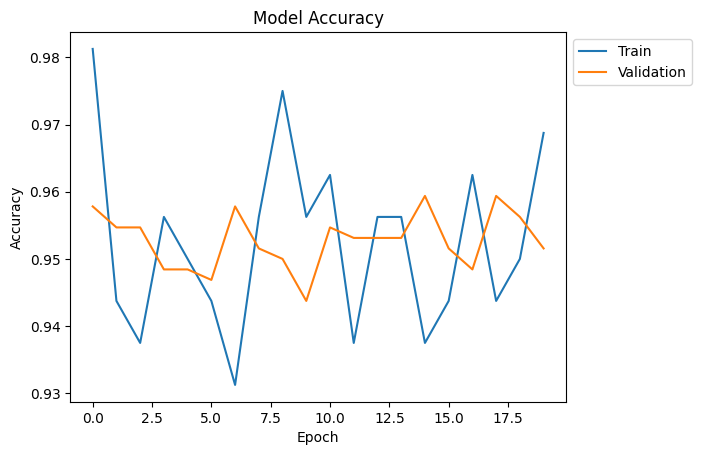

In [57]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## **INCEPTION V3**

In [68]:
from tensorflow.keras.applications import InceptionV3
base_model_6 = tf.keras.applications.InceptionV3(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')


In [69]:
for layer in base_model_6.layers:
  layer.trainable=False

In [74]:


x3 = Flatten()(base_model_6.output)

x3 = Dense(4096, activation='relu')(x3)


x3 = Dense(2048, activation='relu')(x3)


x3 = Dense(1024, activation='relu')(x3)


x3 = Dense(1024, activation='relu')(x3)


x3 = Dense(4, activation='softmax')(x3)




In [75]:
model4=Model(inputs=base_model_6.input,outputs=x3)

In [77]:
model4.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model4.fit(train_dataset,
                    validation_data=validation_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs = 20,
                    verbose=1)


Epoch 1/20
160/160 [==============================] - 19s 76ms/step - loss: 34.5396 - accuracy: 0.4873 - auc_9: 0.7456 - precision_9: 0.5157 - recall_9: 0.4006 - val_loss: 0.9973 - val_accuracy: 0.5609 - val_auc_9: 0.8383 - val_precision_9: 0.6190 - val_recall_9: 0.4875
Epoch 2/20
160/160 [==============================] - 12s 76ms/step - loss: 0.9490 - accuracy: 0.5367 - auc_9: 0.8293 - precision_9: 0.6168 - recall_9: 0.4090 - val_loss: 0.9560 - val_accuracy: 0.5437 - val_auc_9: 0.8335 - val_precision_9: 0.6376 - val_recall_9: 0.4234
Epoch 3/20
160/160 [==============================] - 12s 70ms/step - loss: 0.9181 - accuracy: 0.5648 - auc_9: 0.8388 - precision_9: 0.6451 - recall_9: 0.4076 - val_loss: 1.0306 - val_accuracy: 0.4859 - val_auc_9: 0.7994 - val_precision_9: 0.5084 - val_recall_9: 0.4234
Epoch 4/20
160/160 [==============================] - 11s 67ms/step - loss: 0.8993 - accuracy: 0.5625 - auc_9: 0.8435 - precision_9: 0.6586 - recall_9: 0.4084 - val_loss: 0.9145 - val_accur

In [79]:
result = model4.evaluate(train_dataset)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

160/160 [==============================] - 10s 59ms/step - loss: 0.7297 - accuracy: 0.6598 - auc_9: 0.9030 - precision_9: 0.8036 - recall_9: 0.4506
Train Loss = 0.7296711802482605
Train Accuracy = 0.6597656011581421
Train AUC = 0.9030096530914307
Train Precision = 0.8035527467727661
Train Recall = 0.4505859315395355


In [80]:
filepath = './InceptionV3_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [82]:
history_6 = model4.fit(train_dataset,
                        validation_data=validation_dataset,
                        steps_per_epoch=len(train_dataset)//32,
                        epochs = 20, callbacks = callback_list,
                        verbose = 1, batch_size=16)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.6438 - auc_9: 0.8995 - precision_9: 0.8349 - recall_9: 0.5688

5/5 [==============================] - 3s 431ms/step - loss: 0.7441 - accuracy: 0.6438 - auc_9: 0.8995 - precision_9: 0.8349 - recall_9: 0.5688 - val_loss: 0.9596 - val_accuracy: 0.5734 - val_auc_9: 0.8591 - val_precision_9: 0.6396 - val_recall_9: 0.5047
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.8430 - accuracy: 0.5750 - auc_9: 0.8658 - precision_9: 0.6446 - recall_9: 0.4875

5/5 [==============================] - 2s 371ms/step - loss: 0.8430 - accuracy: 0.5750 - auc_9: 0.8658 - precision_9: 0.6446 - recall_9: 0.4875 - val_loss: 0.9153 - val_accuracy: 0.5547 - val_auc_9: 0.8434 - val_precision_9: 0.6535 - val_recall_9: 0.4656
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.6875 - auc_9: 0.9082 - precision_9: 0.7500 - recall_9: 0.5813

5/5 [==============================] - 1s 359ms/step - loss: 0.7073 - accuracy: 0.6875 - auc_9: 0.9082 - precision_9: 0.7500 - recall_9: 0.5813 - val_loss: 0.8506 - val_accuracy: 0.6031 - val_auc_9: 0.8699 - val_precision_9: 0.6853 - val_recall_9: 0.4969
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.6938 - auc_9: 0.9087 - precision_9: 0.7565 - recall_9: 0.5437

5/5 [==============================] - 2s 444ms/step - loss: 0.7032 - accuracy: 0.6938 - auc_9: 0.9087 - precision_9: 0.7565 - recall_9: 0.5437 - val_loss: 0.8126 - val_accuracy: 0.6203 - val_auc_9: 0.8804 - val_precision_9: 0.7321 - val_recall_9: 0.5125
Epoch 5/20
5/5 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.6938 - auc_9: 0.9123 - precision_9: 0.7736 - recall_9: 0.5125

5/5 [==============================] - 2s 597ms/step - loss: 0.6877 - accuracy: 0.6938 - auc_9: 0.9123 - precision_9: 0.7736 - recall_9: 0.5125 - val_loss: 0.8108 - val_accuracy: 0.6141 - val_auc_9: 0.8783 - val_precision_9: 0.7346 - val_recall_9: 0.4844
Epoch 6/20
4/5 [=======================>......] - ETA: 0s - loss: 0.6685 - accuracy: 0.7656 - auc_9: 0.9284 - precision_9: 0.8222 - recall_9: 0.5781

5/5 [==============================] - 2s 373ms/step - loss: 0.6778 - accuracy: 0.7312 - auc_9: 0.9220 - precision_9: 0.8036 - recall_9: 0.5625 - val_loss: 0.8040 - val_accuracy: 0.6313 - val_auc_9: 0.8845 - val_precision_9: 0.7054 - val_recall_9: 0.5500
Epoch 7/20
5/5 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.6438 - auc_9: 0.8928 - precision_9: 0.7120 - recall_9: 0.5562

5/5 [==============================] - 3s 817ms/step - loss: 0.7542 - accuracy: 0.6438 - auc_9: 0.8928 - precision_9: 0.7120 - recall_9: 0.5562 - val_loss: 0.8322 - val_accuracy: 0.5953 - val_auc_9: 0.8690 - val_precision_9: 0.6700 - val_recall_9: 0.5172
Epoch 8/20
5/5 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.6875 - auc_9: 0.9250 - precision_9: 0.7920 - recall_9: 0.6187

5/5 [==============================] - 2s 406ms/step - loss: 0.6560 - accuracy: 0.6875 - auc_9: 0.9250 - precision_9: 0.7920 - recall_9: 0.6187 - val_loss: 0.8204 - val_accuracy: 0.6203 - val_auc_9: 0.8792 - val_precision_9: 0.7048 - val_recall_9: 0.5297
Epoch 9/20
5/5 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.7500 - auc_9: 0.9178 - precision_9: 0.7925 - recall_9: 0.5250

5/5 [==============================] - 2s 374ms/step - loss: 0.6916 - accuracy: 0.7500 - auc_9: 0.9178 - precision_9: 0.7925 - recall_9: 0.5250 - val_loss: 0.8059 - val_accuracy: 0.6281 - val_auc_9: 0.8833 - val_precision_9: 0.7476 - val_recall_9: 0.4859
Epoch 10/20
5/5 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.6625 - auc_9: 0.9228 - precision_9: 0.8125 - recall_9: 0.5688

5/5 [==============================] - 1s 358ms/step - loss: 0.6276 - accuracy: 0.6625 - auc_9: 0.9228 - precision_9: 0.8125 - recall_9: 0.5688 - val_loss: 0.8045 - val_accuracy: 0.6359 - val_auc_9: 0.8844 - val_precision_9: 0.7293 - val_recall_9: 0.5219
Epoch 11/20
5/5 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7563 - auc_9: 0.9460 - precision_9: 0.8534 - recall_9: 0.6187

5/5 [==============================] - 2s 362ms/step - loss: 0.5672 - accuracy: 0.7563 - auc_9: 0.9460 - precision_9: 0.8534 - recall_9: 0.6187 - val_loss: 0.9168 - val_accuracy: 0.6172 - val_auc_9: 0.8774 - val_precision_9: 0.6599 - val_recall_9: 0.5609
Epoch 12/20
5/5 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.6687 - auc_9: 0.9215 - precision_9: 0.6738 - recall_9: 0.5938

5/5 [==============================] - 1s 343ms/step - loss: 0.6241 - accuracy: 0.6687 - auc_9: 0.9215 - precision_9: 0.6738 - recall_9: 0.5938 - val_loss: 0.8517 - val_accuracy: 0.5953 - val_auc_9: 0.8705 - val_precision_9: 0.6891 - val_recall_9: 0.4953
Epoch 13/20
4/5 [=======================>......] - ETA: 0s - loss: 0.6027 - accuracy: 0.7188 - auc_9: 0.9299 - precision_9: 0.7667 - recall_9: 0.5391

5/5 [==============================] - 1s 358ms/step - loss: 0.6350 - accuracy: 0.6812 - auc_9: 0.9198 - precision_9: 0.7434 - recall_9: 0.5250 - val_loss: 0.8793 - val_accuracy: 0.5906 - val_auc_9: 0.8605 - val_precision_9: 0.6392 - val_recall_9: 0.5094
Epoch 14/20
4/5 [=======================>......] - ETA: 0s - loss: 0.7209 - accuracy: 0.7031 - auc_9: 0.9118 - precision_9: 0.7500 - recall_9: 0.6094

5/5 [==============================] - 2s 374ms/step - loss: 0.7377 - accuracy: 0.6625 - auc_9: 0.9006 - precision_9: 0.7077 - recall_9: 0.5750 - val_loss: 0.9396 - val_accuracy: 0.6016 - val_auc_9: 0.8704 - val_precision_9: 0.6383 - val_recall_9: 0.5516
Epoch 15/20
5/5 [==============================] - ETA: 0s - loss: 0.8384 - accuracy: 0.6062 - auc_9: 0.8768 - precision_9: 0.6197 - recall_9: 0.5500

5/5 [==============================] - 2s 514ms/step - loss: 0.8384 - accuracy: 0.6062 - auc_9: 0.8768 - precision_9: 0.6197 - recall_9: 0.5500 - val_loss: 0.9224 - val_accuracy: 0.6297 - val_auc_9: 0.8672 - val_precision_9: 0.6655 - val_recall_9: 0.5844
Epoch 16/20
5/5 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.6812 - auc_9: 0.9114 - precision_9: 0.7293 - recall_9: 0.6062

5/5 [==============================] - 2s 468ms/step - loss: 0.7077 - accuracy: 0.6812 - auc_9: 0.9114 - precision_9: 0.7293 - recall_9: 0.6062 - val_loss: 0.8816 - val_accuracy: 0.5922 - val_auc_9: 0.8600 - val_precision_9: 0.6767 - val_recall_9: 0.4938
Epoch 17/20
5/5 [==============================] - ETA: 0s - loss: 0.7838 - accuracy: 0.6500 - auc_9: 0.8881 - precision_9: 0.7143 - recall_9: 0.5312

5/5 [==============================] - 2s 372ms/step - loss: 0.7838 - accuracy: 0.6500 - auc_9: 0.8881 - precision_9: 0.7143 - recall_9: 0.5312 - val_loss: 0.8403 - val_accuracy: 0.6156 - val_auc_9: 0.8763 - val_precision_9: 0.6938 - val_recall_9: 0.5203
Epoch 18/20
5/5 [==============================] - ETA: 0s - loss: 0.7840 - accuracy: 0.6500 - auc_9: 0.8893 - precision_9: 0.6935 - recall_9: 0.5375

5/5 [==============================] - 2s 367ms/step - loss: 0.7840 - accuracy: 0.6500 - auc_9: 0.8893 - precision_9: 0.6935 - recall_9: 0.5375 - val_loss: 0.8306 - val_accuracy: 0.6187 - val_auc_9: 0.8724 - val_precision_9: 0.6838 - val_recall_9: 0.5406
Epoch 19/20
5/5 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.6687 - auc_9: 0.9010 - precision_9: 0.7120 - recall_9: 0.5562

5/5 [==============================] - 1s 357ms/step - loss: 0.7390 - accuracy: 0.6687 - auc_9: 0.9010 - precision_9: 0.7120 - recall_9: 0.5562 - val_loss: 0.8335 - val_accuracy: 0.6141 - val_auc_9: 0.8758 - val_precision_9: 0.6698 - val_recall_9: 0.5578
Epoch 20/20
5/5 [==============================] - ETA: 0s - loss: 0.8260 - accuracy: 0.6812 - auc_9: 0.8915 - precision_9: 0.7083 - recall_9: 0.6375

5/5 [==============================] - 1s 365ms/step - loss: 0.8260 - accuracy: 0.6812 - auc_9: 0.8915 - precision_9: 0.7083 - recall_9: 0.6375 - val_loss: 0.8436 - val_accuracy: 0.6156 - val_auc_9: 0.8686 - val_precision_9: 0.6892 - val_recall_9: 0.5094


In [83]:
model4.evaluate(test_dataset)

20/20 [==============================] - 2s 44ms/step - loss: 0.8249 - accuracy: 0.6219 - auc_9: 0.8758 - precision_9: 0.6881 - recall_9: 0.4859


[0.8249326944351196,
 0.621874988079071,
 0.8757592439651489,
 0.6880530714988708,
 0.4859375059604645]

In [84]:
result = model4.evaluate(test_dataset)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]

print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

20/20 [==============================] - 2s 62ms/step - loss: 0.8006 - accuracy: 0.6156 - auc_9: 0.8813 - precision_9: 0.6872 - recall_9: 0.4875
Test Loss = 0.8006261587142944
Test Accuracy = 0.6156250238418579
Test AUC = 0.8813208341598511
Test Precision = 0.6872246861457825
Test Recall = 0.48750001192092896


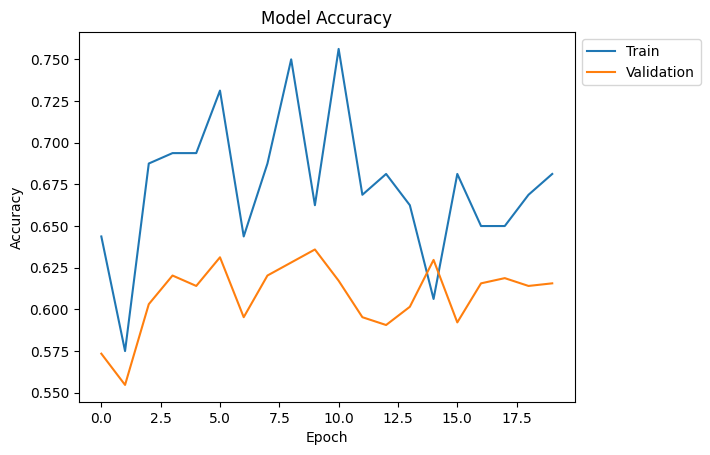

In [85]:
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## **Prediction**

In [86]:
models1=["VGG","RESNET50","DensNET","Inception V3"]

In [87]:

print(models1)
print(acc)

['VGG', 'RESNET50', 'DensNET', 'Inception V3']
[90.3124988079071, 90.78124761581421, 89.3750011920929, 61.56250238418579]


1/1 [==============================] - 0s 37ms/step
100.0 % chances are there that the image is Very_Mild_Demented


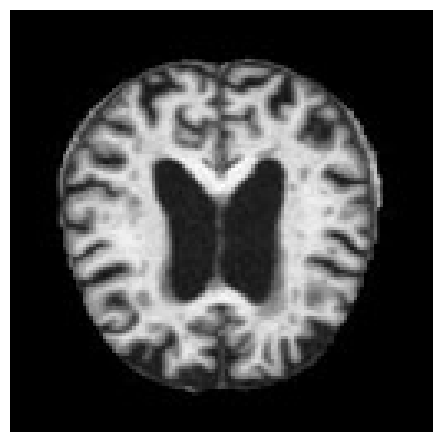

In [139]:
dic = test_data_final.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Dataset/Very_Mild_Demented/verymild_10.jpg', target_size = (128,128,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
# answer = model.predict_classes(img)
predict_x=model2.predict(img) 
classes_x=np.argmax(predict_x,axis=1)
probability = round(np.max(model.predict(img)*100),2)
print(probability, '% chances are there that the image is',idc[classes_x[0]])

## **Accuracy Plot**

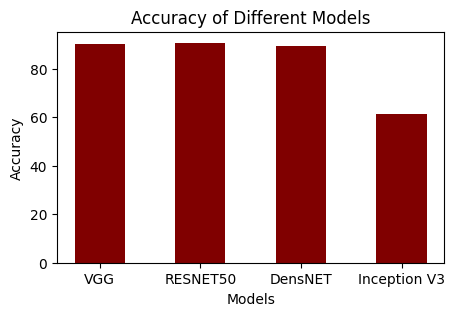

In [93]:
fig = plt.figure(figsize = (5, 3))
plt.bar(models1, acc, color ='maroon',
        width = 0.5)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Models")
plt.show()

In [94]:
model3.save("vgg.h5")
model2.save("resnet.h5")
model.save("densenet.h5")
model4.save("inception.h5")

### **Streamlit Deployment**

In [100]:
max = acc[0];         
maxname = None
if len(acc) > 0:
    max = acc[0]
    maxname = models1[0]
    for i in range(1, len(models1)):
        if acc[i] > max:
            max = acc[i]
            maxname = models1[i]
if maxname == 'vgg':
    model3.save("vgg.h5")
    model3.load_weights("vgg.h5")
elif maxname == 'resnet':
  model2.save("resnet.h5")
  model2.load_weights("resnet.h5")
elif maxname == 'densenet':
  model.save("densenet.h5")
  model.load_weights("densenet.h5")
elif maxname == 'inception':
  model.save("inception.h5")
  model.load_weights("inception.h5")

print("Best Accuracy Model is "+maxname+" with accuracy of "+ str(max)); 
aa=maxname+'.h5'  

Best Accuracy Model is RESNET50 with accuracy of 90.78124761581421


In [101]:
print(aa)

RESNET50.h5


In [102]:
tensorflow.keras.models.save_model(model,'resnet.h5')

In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=f5ef58cc161905cea758ada60f2d4c2c070bcf719e1c91a50567595ee3577a45
  Stored in directory: /root/.cache/pip/wheels/2d/f0/a8/1094fca7a7e5d0d12ff56e0c64675d72aa5cc81a5fc200e849
Successfully built validators


In [ ]:
! pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19879 sha256=01573a165f4cb5e05c9c72e5db7afd55bf9d8a9a71a5cd65301886ef700bf001
  Stored in directory: /root/.cache/pip/wheels/31/49/9c/44b13823eb256a3b4dff34b972f7a3c7d9910bfef269e59bd7
Successfully built pyngrok


In [ ]:
from tensorflow.keras.utils import load_img,img_to_array

In [ ]:
%%writefile img_classification.py
from PIL import Image
from tensorflow.keras.utils import load_img,img_to_array
import numpy as np
import keras
from keras.models import load_model
from PIL import Image, ImageOps
def teachable_machine_classification(img, weights_file):
    
    model = keras.models.load_model(weights_file)

    
    data = np.ndarray(shape=(1, 128, 128, 3), dtype=np.float32)
    image = img
  
    size = (128, 128)
    image = ImageOps.fit(image, size, Image.ANTIALIAS)

  
    image_array = np.asarray(image)
  
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

  
    data[0] = normalized_image_array

    prediction = model.predict(data)
    return np.argmax(prediction)

Writing img_classification.py


In [ ]:
import streamlit as st
from img_classification import teachable_machine_classification
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import keras
st.title("Demented and Non demented")
st.header("Alzheimer's disease Classification using MRI imgae data")
st.text("Upload a brain MRI Image for Alzheimer's disease")
     
uploaded_file = st.file_uploader("Choose an image...", type=["jpg","png","jpeg"])
if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("Classifying...")
    
    st.write("")
    label = teachable_machine_classification(image, 'DenseNet_169.h5')
    if label == 0:
       st.write("Demented")
    else:
       st.write("Non demented")
        
        

  command:

    streamlit run /usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py [ARGUMENTS]
2023-04-24 06:56:24.893 
  command:

    streamlit run /usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py [ARGUMENTS]


In [ ]:
!ngrok authtoken 2Mp36PPMXuDhK7aeyyW4dvwD0Qi_4bpseM6dpiqgMLKA7wDAi

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(5000)
public_url

INFO:pyngrok.ngrok:Opening tunnel named: http-5000-8ac5fbff-a7fc-41cd-b7e1-507fd6d3dcda
2023-04-24 06:56:39.530 Opening tunnel named: http-5000-8ac5fbff-a7fc-41cd-b7e1-507fd6d3dcda
INFO:pyngrok.process.ngrok:t=2023-04-24T06:56:39+0000 lvl=info msg="no configuration paths supplied"
2023-04-24 06:56:39.632 t=2023-04-24T06:56:39+0000 lvl=info msg="no configuration paths supplied"
2023-04-24 06:56:39.642 t=2023-04-24T06:56:39+0000 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=/root/.config/ngrok/ngrok.yml legacy_path=/root/.ngrok2/ngrok.yml
INFO:pyngrok.process.ngrok:t=2023-04-24T06:56:39+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
2023-04-24 06:56:39.646 t=2023-04-24T06:56:39+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
INFO:pyngrok.process.ngrok:t=2023-04-24T06:56:39+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
2023-04-24 0

<NgrokTunnel: "https://7aa1-34-142-180-118.ngrok-free.app" -> "http://localhost:5000">

2023-04-24 06:56:40.617 t=2023-04-24T06:56:40+0000 lvl=info msg=end pg=/api/tunnels id=0c52fa2834cb41ea status=201 dur=238.141648ms


In [ ]:

!streamlit run /content/img_classification.py & npx localtunnel --port 5000


[..................] | fetchMetadata: sill resolveWithNewModule axios@0.21.4 ch

npx: installed 22 in 4.734s

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.142.180.118:8501



INFO:pyngrok.process.ngrok:t=2023-04-24T07:19:54+0000 lvl=info msg="received stop request" obj=app stopReq="{err:<nil> restart:false}"
2023-04-24 07:19:54.071 t=2023-04-24T07:19:54+0000 lvl=info msg="received stop request" obj=app stopReq="{err:<nil> restart:false}"


  Stopping...
^C
